In [1]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\cahaya irham\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [33]:
import opendatasets as od
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import shutil
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

SAVED_MODEL_PATH = "./image model new.h5"

In [8]:
od.download('https://www.kaggle.com/datasets/karandeep98/real-life-violence-and-nonviolence-data')

Skipping, found downloaded files in ".\real-life-violence-and-nonviolence-data" (use force=True to force download)


In [9]:
rootdir = 'real-life-violence-and-nonviolence-data/violence_dataset'
classes = ['non_violence', 'violence']


for i in classes:

  os.makedirs(rootdir +'/train/' + i)

  os.makedirs(rootdir +'/test/' + i)

  source = rootdir + '/' + i

  allFileNames = os.listdir(source)

  np.random.shuffle(allFileNames)

  test_ratio = 0.25

  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - test_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train/' + i)

  for name in test_FileNames:
    shutil.copy(name, rootdir +'/test/' + i)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'real-life-violence-and-nonviolence-data/violence_dataset/train/non_violence'

In [60]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [61]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=True)

In [22]:
def create_model():
    model = tf.keras.models.Sequential([
      feature_extractor,
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
    
    return model


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(rootdir, 'train')
validation_dir = os.path.join(rootdir, 'test')

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=40,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  shear_range=0.2,
                  zoom_range=0.2,
                  horizontal_flip=True,
                  fill_mode='nearest')
test_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=40,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  shear_range=0.2,
                  zoom_range=0.2,
                  horizontal_flip=True,
                  fill_mode='nearest')

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 8297 images belonging to 2 classes.
Found 2766 images belonging to 2 classes.


In [24]:
EPOCHS = 17

# Create a new model
model = create_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,946,753
Trainable params: 2,912,641
Non-trainable params: 34,112
_________________________________________________________________


In [25]:
history = model.fit(
      train_generator,
      steps_per_epoch=414,  # 2000 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=138,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/17
414/414 - 1273s - loss: 0.3424 - accuracy: 0.8885 - val_loss: 0.2387 - val_accuracy: 0.9413 - 1273s/epoch - 3s/step
Epoch 2/17
414/414 - 1182s - loss: 0.2255 - accuracy: 0.9443 - val_loss: 0.2102 - val_accuracy: 0.9565 - 1182s/epoch - 3s/step
Epoch 3/17
414/414 - 1531s - loss: 0.2004 - accuracy: 0.9552 - val_loss: 0.2298 - val_accuracy: 0.9493 - 1531s/epoch - 4s/step
Epoch 4/17
414/414 - 2145s - loss: 0.1847 - accuracy: 0.9641 - val_loss: 0.2457 - val_accuracy: 0.9543 - 2145s/epoch - 5s/step
Epoch 5/17
414/414 - 1406s - loss: 0.1642 - accuracy: 0.9714 - val_loss: 0.2124 - val_accuracy: 0.9641 - 1406s/epoch - 3s/step
Epoch 6/17
414/414 - 1178s - loss: 0.1549 - accuracy: 0.9734 - val_loss: 0.1984 - val_accuracy: 0.9743 - 1178s/epoch - 3s/step
Epoch 7/17
414/414 - 1158s - loss: 0.1522 - accuracy: 0.9768 - val_loss: 0.1843 - val_accuracy: 0.9728 - 1158s/epoch - 3s/step
Epoch 8/17
414/414 - 1198s - loss: 0.1498 - accuracy: 0.9784 - val_loss: 0.1848 - val_accuracy: 0.9743 - 1198s/

In [26]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

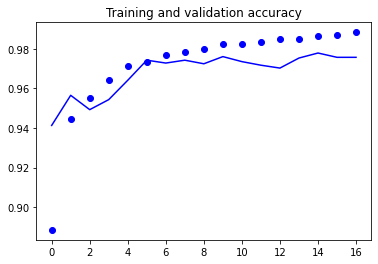

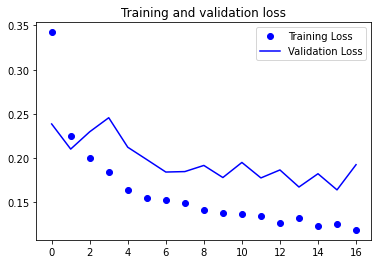

In [27]:
plot_loss_acc(history)

In [29]:
from keras.preprocessing import image

path = 'real-life-violence-and-nonviolence-data/foto-tangkapan-layar-72.jpg'

img=image.load_img(path, target_size=(224, 224))
x=image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

np.shape(x)

(1, 224, 224, 3)

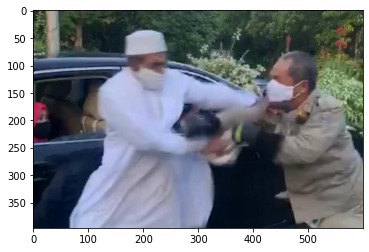

In [30]:
import matplotlib.image as mpimg
img = mpimg.imread(path)
plt.imshow(img)
plt.show()

In [31]:
print(model.predict(x)[0,0])

0.98220855


In [32]:
if model.predict(x)[0,0] > 0.5:
    print('violence')
else:
    print('non violence')

violence


In [34]:
model.save(SAVED_MODEL_PATH)

In [57]:
tflite_dir = './tflite/'+str(2)

model.summary()

if os.path.isdir(tflite_dir) != True:
    os.mkdir(tflite_dir)
    tf.saved_model.save(model, tflite_dir)


converter = tf.lite.TFLiteConverter.from_saved_model(tflite_dir) 
model_converted = converter.convert()

with open(tflite_dir+'/model.tflite', 'wb') as tflite:
  tflite.write(model_converted)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_23 (Dense)            (None, 512)               655872    
                                                                 
 dense_24 (Dense)            (None, 64)                32832     
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,946,753
Trainable params: 2,912,641
Non-trainable params: 34,112
_________________________________________________________________
INFO:tensorflow:Assets written to: ./tflite/2\assets


INFO:tensorflow:Assets written to: ./tflite/2\assets


In [59]:
tf.saved_model.save(model, tflite_dir)

INFO:tensorflow:Assets written to: ./tflite/2\assets


INFO:tensorflow:Assets written to: ./tflite/2\assets
